In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

In [2]:
from jcm.model import Model, get_coords
from jcm.boundaries import initialize_boundaries

realistic_boundaries = lambda coords=get_coords(): initialize_boundaries(
    '../jcm/data/bc/t30/clim/boundaries_daily.nc',
    coords.horizontal,
)

In [3]:
model = Model(
    save_interval=3,
    total_time=240,
    boundaries=realistic_boundaries(),
)
state = model.get_initial_state()
final_state, predictions = model.unroll(state)

In [4]:
pred_ds = model.predictions_to_xarray(predictions)

In [5]:
print(f"dataset size: {pred_ds.nbytes/1e6:.1f}MB")

dataset size: 293.4MB


/tmp/ipykernel_2576127/1173979372.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.max(pred_ds['humidity.rh'].values, axis=(1,2,3))))


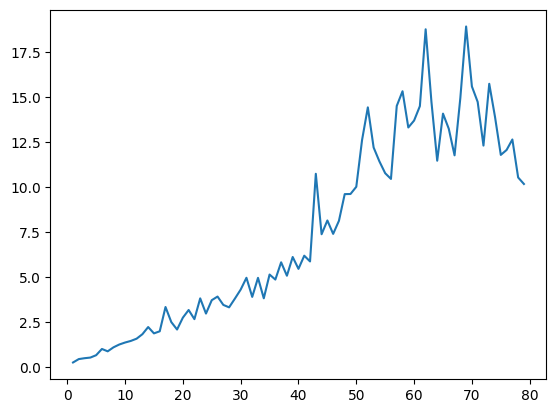

In [6]:
plt.plot(np.log(np.max(pred_ds['humidity.rh'].values, axis=(1,2,3))))

/tmp/ipykernel_2576127/1750675446.py:14: RuntimeWarning: divide by zero encountered in log
  values = np.log(np.percentile(variable[:,i,:,:], p, axis=(1,2)))
/tmp/ipykernel_2576127/1750675446.py:18: RuntimeWarning: divide by zero encountered in log
  x_min, x_max = 0, len(np.log(np.percentile(variable[:,0,:,:], 20, axis=(1,2))))
/tmp/ipykernel_2576127/1750675446.py:25: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.percentile(variable[:,i,:,:], p, axis=(1,2))),


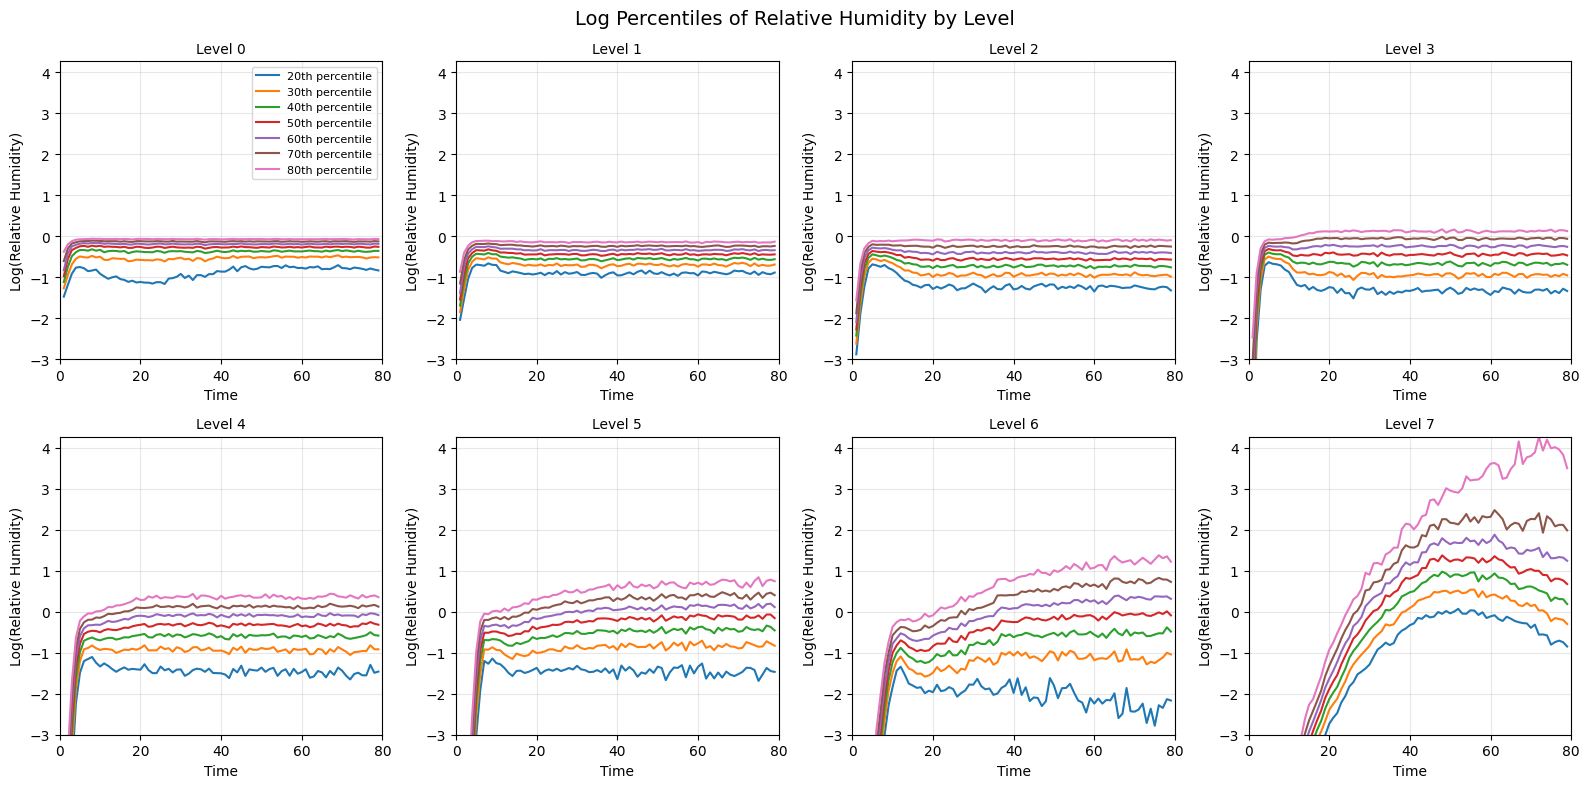

In [7]:
# Create a 2x4 grid of subplots (8 subplots total for i in range(8))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Log Percentiles of Relative Humidity by Level', fontsize=14)

# Flatten axes array for easier indexing
axes_flat = axes.flatten()

variable = pred_ds['humidity.rh'].values + np.zeros((1,8,1,1))

# Calculate global min/max for consistent axes
all_values = []
for i in range(8):
    for p in [20, 30, 40, 50, 60, 70, 80]:
        values = np.log(np.percentile(variable[:,i,:,:], p, axis=(1,2)))
        all_values.extend(values)

y_min, y_max = np.nanmin(all_values), np.nanmax(all_values)
x_min, x_max = 0, len(np.log(np.percentile(variable[:,0,:,:], 20, axis=(1,2))))

for i in range(8):
    ax = axes_flat[i]
    
    # Plot percentile lines for this level
    for p in [20, 30, 40, 50, 60, 70, 80]:
        ax.plot(np.log(np.percentile(variable[:,i,:,:], p, axis=(1,2))), 
                label=f'{p}th percentile')
    
    # Set consistent axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-3, y_max)
    
    # Set title and labels for each subplot
    ax.set_title(f'Level {i}', fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Log(Relative Humidity)')
    ax.grid(True, alpha=0.3)
    
    # Add legend only to the first subplot to avoid clutter
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()